# Variational Bayesian Last Layer (VBLL) with SNGP Regression

In [1]:
%pip install lightning-uq-box

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import os
from functools import partial
from torch.optim import Adam
from lightning_uq_box.uq_methods import SNGPRegression, VBLLRegression
from lightning_uq_box.datamodules import ToyDUE
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.models.fc_resnet import FCResNet
from lightning_uq_box.viz_utils import (
    plot_toy_regression_data,
    plot_predictions_regression,
    plot_training_metrics,
)

import tempfile

%load_ext autoreload
%autoreload 2

In [3]:
# temporary directory for saving
my_temp_dir = tempfile.mkdtemp()

seed_everything(42)

Seed set to 42


42

## Datamodule

In [4]:
datamodule = ToyDUE(batch_size=32, n_samples=128)
datamodule.__dict__.keys()
X_train, y_train, X_test, y_test, train_loader, test_loader = (
    datamodule.X_train,
    datamodule.y_train,
    datamodule.X_test,
    datamodule.y_test,
    datamodule.train_dataloader(),
    datamodule.val_dataloader(),
)

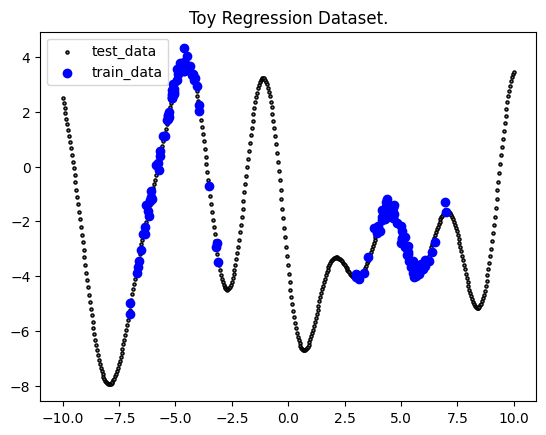

In [5]:
fig = plot_toy_regression_data(X_train, y_train, X_test, y_test)

## Model

In [37]:
feature_extractor = FCResNet(input_dim=1, features=64, depth=4, num_outputs=128, dropout_rate=0.0, activation="elu")
feature_extractor

FCResNet(
  (first): Linear(in_features=1, out_features=64, bias=True)
  (residuals): ModuleList(
    (0-3): 4 x Linear(in_features=64, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (last): Linear(in_features=64, out_features=128, bias=True)
)

In [38]:
vbll_model = VBLLRegression(
    model=feature_extractor,
    regularization_weight=(1 / X_train.shape[0]),
    optimizer=partial(torch.optim.AdamW, lr=1e-3, weight_decay=1e-4),
    prior_scale=1.0,
    wishart_scale=0.1
)

## Trainer

In [39]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=400,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=True,
    default_root_dir=my_temp_dir,
    gradient_clip_val=1.0
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [40]:
trainer.fit(vbll_model, datamodule)


  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Sequential       | 41.7 K
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
41.7 K    Trainable params
1         Non-trainable params
41.7 K    Total params
0.167     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/nils/miniconda3/envs/py311uqbox/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/nils/miniconda3/envs/py311uqbox/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 399: 100%|██████████| 4/4 [00:00<00:00, 39.11it/s, v_num=4] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 4/4 [00:00<00:00, 37.92it/s, v_num=4]


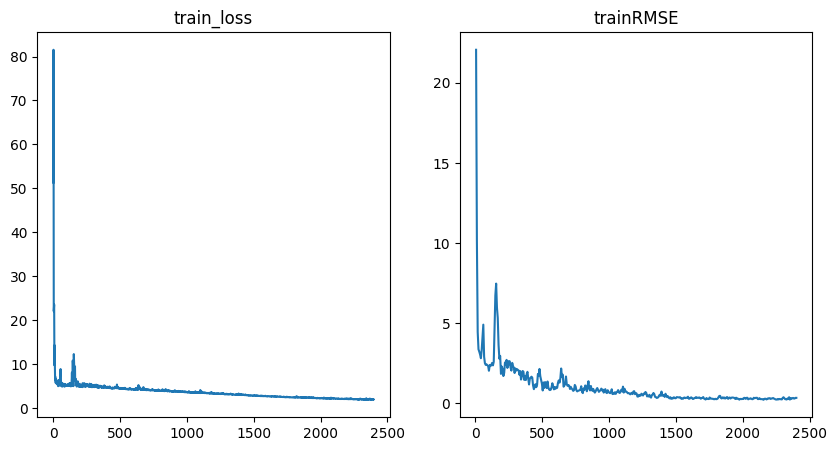

In [41]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "trainRMSE"]
)

## Prediction

In [42]:
preds = vbll_model.predict_step(X_test)

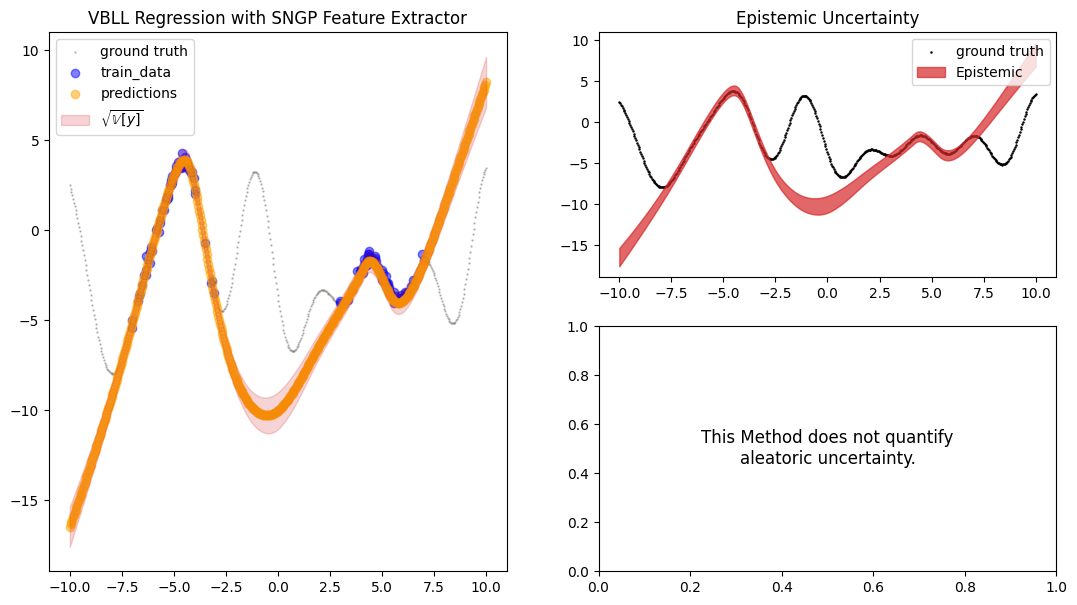

In [43]:
fig = plot_predictions_regression(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["pred"],
    preds["pred_uct"].squeeze(-1),
    epistemic=preds["pred_uct"].squeeze(-1),
    title="VBLL Regression with SNGP Feature Extractor",
    show_bands=True,
)